**Importing libraries**

In [1]:
import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pickle
import pandas as pd
import numpy as np
import random

**Importing dataset**

In [2]:
# loading sign names dataset
data = pd.read_csv("german-traffic-signs/signnames.csv")
data

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [3]:
# loading the pickled datasets

with open("german-traffic-signs/train.p", mode='rb') as training:
    train = pickle.load(training)

with open("german-traffic-signs/test.p", mode='rb') as testing:
    test = pickle.load(testing)

with open("german-traffic-signs/valid.p", mode='rb') as validation:
    valid = pickle.load(validation)

In [4]:
# splitting dataset for training and testing
# split using dictionary labels - features and labels
# features contain the raw pixel values of the images
# labels contain the corresponding class_id
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [5]:
# printing the dimensions of the data
# (number of images, height, width, rgb)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


11    Right-of-way at the next intersection
Name: SignName, dtype: object


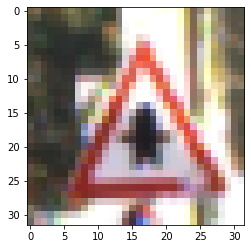

In [6]:
# printing sample image from dataset
index = np.random.randint(1, len(X_train))
plt.imshow(X_train[index])
id = y_train[index]
print(data[data["ClassId"]==id]["SignName"])

## Image Preprocessing

In [7]:
# Shuffling the dataset
# Done since images are grouped and ordered in the dataset
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

*   Converting to grayscale
*   Histogram equalization
*   Normalization



In [8]:
def preprocessing(img):
    # grayscale conversion - Done so that the model is less computationally intensive
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # histogram equilization - to adjust the images' contrast and evenly expose it
    img = cv2.equalizeHist(img)
    # Normalization - to get pixel values between zero and one
    img = img/255

    return img


In [9]:
# Applying the function to the every pixel of the images using map function
X_train_processed =  np.array(list(map(preprocessing, X_train)))
X_validation_processed = np.array(list(map(preprocessing, X_valid)))
X_test_processed = np.array(list(map(preprocessing, X_test)))


In [10]:
# Grouping the pixels back to the images
# Number of images, resolution(height * width), number of channels
X_train_processed = X_train_processed.reshape(34799, 32, 32, 1)
X_test_processed = X_test_processed.reshape(12630, 32, 32, 1)
X_validation_processed = X_validation_processed.reshape(4410, 32, 32, 1)

In [11]:
print(X_train_processed.shape)
print(X_test_processed.shape)
print(X_validation_processed.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


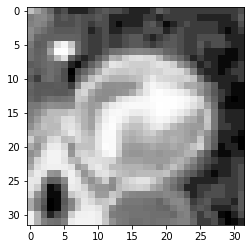

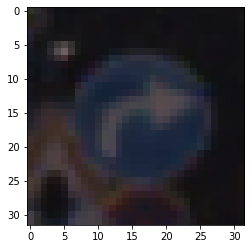

In [12]:
i = random.randint(1, len(X_train))
plt.imshow(X_train_processed[i].squeeze(), cmap='gray')
plt.figure()
plt.imshow(X_train[i].squeeze())

## Building the model

In [13]:
model = Sequential()

# Adding convolution layer
# Conv2D parameters:
# 32: resolution of image
# 5, 5 : size of the filter
model.add(Conv2D(32, (5,5), activation='relu', input_shape=(32,32,1)))

# pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

# dropout layer
model.add(Dropout(0.25))

# Second Convolution layer and pooling layer
model.add(Conv2D(64, (5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten the image to one dimension, 
# i.e. into a long vector or array instead of a matrix
model.add(Flatten())

# Dense layer
model.add(Dense(256, activation='relu'))

# second dropout layer, 0.5 drop rate
model.add(Dropout(0.5))

# final output layer
model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0

In [14]:
# compile the model
model.compile(Adam(lr=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


D:\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
history = model.fit(X_train_processed,
                    y_train,
                    batch_size=500,
                    epochs=50,
                    verbose=1,
                    validation_data=(X_validation_processed, y_valid))

Epoch 1/50
70/70 [==============================] - 38s 522ms/step - loss: 3.5561 - accuracy: 0.0636 - val_loss: 3.4642 - val_accuracy: 0.2020
Epoch 2/50
70/70 [==============================] - 32s 463ms/step - loss: 3.2644 - accuracy: 0.1624 - val_loss: 3.0376 - val_accuracy: 0.3159
Epoch 3/50
70/70 [==============================] - 30s 426ms/step - loss: 2.7105 - accuracy: 0.3192 - val_loss: 2.4197 - val_accuracy: 0.4313
Epoch 4/50
70/70 [==============================] - 30s 429ms/step - loss: 2.2078 - accuracy: 0.4179 - val_loss: 1.9654 - val_accuracy: 0.4948
Epoch 5/50
70/70 [==============================] - 31s 447ms/step - loss: 1.8777 - accuracy: 0.4788 - val_loss: 1.6515 - val_accuracy: 0.5571
Epoch 6/50
70/70 [==============================] - 30s 434ms/step - loss: 1.6427 - accuracy: 0.5286 - val_loss: 1.4126 - val_accuracy: 0.6143
Epoch 7/50
70/70 [==============================] - 35s 496ms/step - loss: 1.4596 - accuracy: 0.5724 - val_loss: 1.2260 - val_accuracy: 0.6760

## Evaluate model performance

In [18]:
score = model.evaluate(X_test_processed, y_test)
print('Test accuracy', score[1])


395/395 [==============================] - 6s 14ms/step - loss: 0.3258 - accuracy: 0.9128
Test accuracy 0.9128265976905823


In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 0, 'epochs')

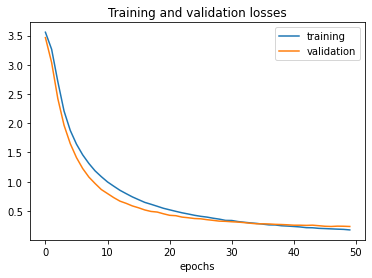

In [22]:
# plotting a graph to check for overfitting/ underfitting
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Training and validation losses')
plt.xlabel("epochs")

Text(0.5, 0, 'epochs')

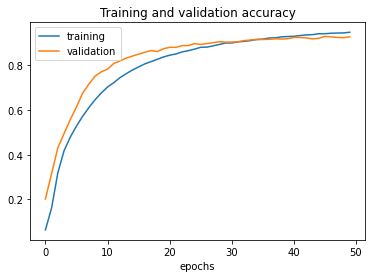

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Training and validation accuracy')
plt.xlabel('epochs')

395/395 [==============================] - 5s 13ms/step


<AxesSubplot:>

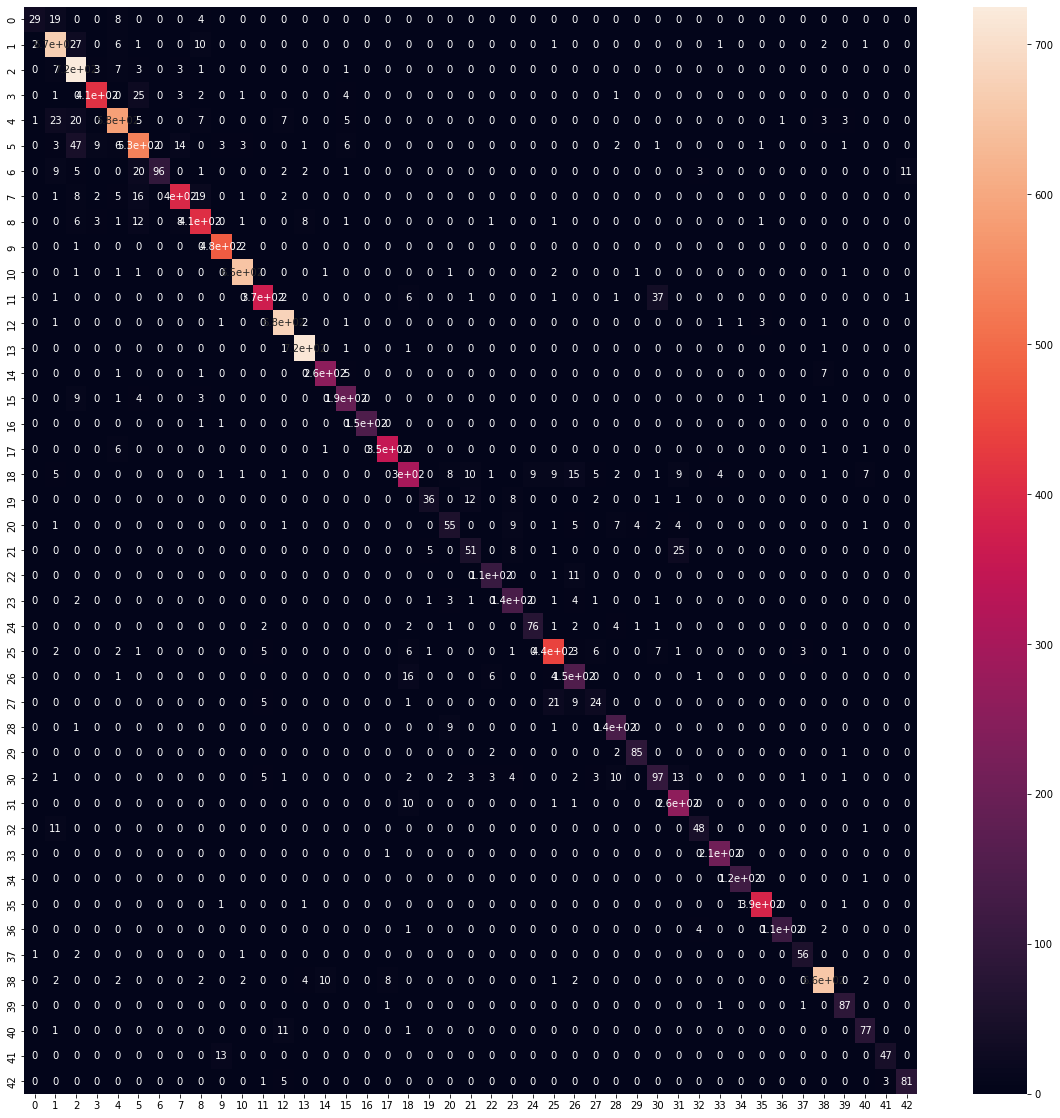

In [35]:
# Generate predictions using testing data
predictions = model.predict(X_test_processed)
predictions = np.argmax(predictions,axis=-1)

from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(20,20))
sns.heatmap(matrix, annot=True)

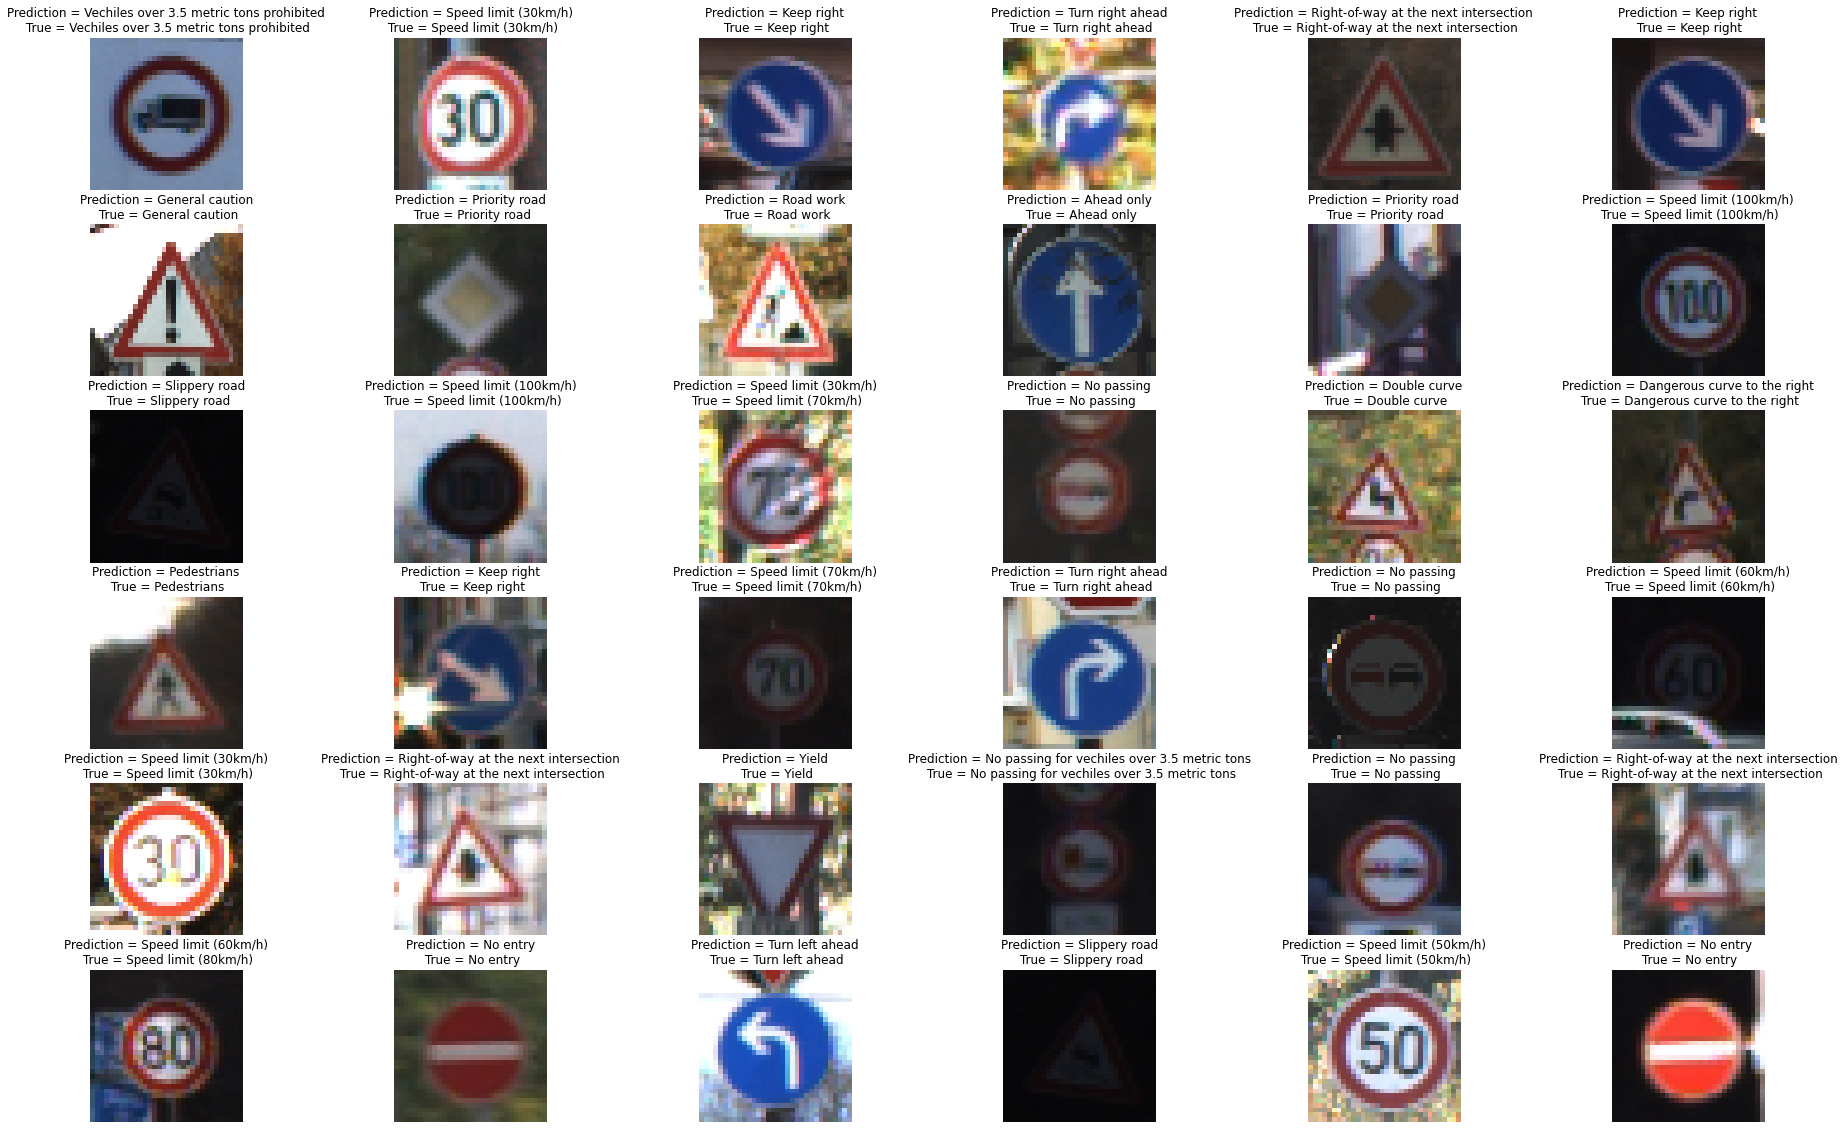

In [50]:
# sample from the predicted data
L=6
W=6

fig, axes = plt.subplots(L,W, figsize=(30,20))
axes = axes.ravel()

for i in range(0, L*W):
    axes[i].imshow(X_test[i])
    preds = data[data["ClassId"] == predictions[i]]["SignName"]
    preds = preds.to_string(index=False, header=False)
    actual = data[data["ClassId"] == y_test[i]]["SignName"]
    actual = actual.to_string(index=False, header=False)
    axes[i].set_title("Prediction = {}\n True = {}".format(preds, actual))
    axes[i].axis('off')
    
plt.subplots_adjust(wspace=1)

In [51]:
model.save("my_model.h5")